<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#vae-example" data-toc-modified-id="vae-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>vae example</a></span></li><li><span><a href="#custom-dataset" data-toc-modified-id="custom-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>custom dataset</a></span></li><li><span><a href="#vae-with-rsample" data-toc-modified-id="vae-with-rsample-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>vae with rsample</a></span></li><li><span><a href="#custom-loss-and-layers" data-toc-modified-id="custom-loss-and-layers-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>custom loss and layers</a></span></li><li><span><a href="#IBP" data-toc-modified-id="IBP-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>IBP</a></span></li><li><span><a href="#sampling-decoder" data-toc-modified-id="sampling-decoder-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sampling decoder</a></span></li><li><span><a href="#POS-vectors" data-toc-modified-id="POS-vectors-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>POS vectors</a></span></li></ul></div>

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.distributions
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Grayscale
from torchvision.utils import save_image
from torchvision.io import read_image

import numpy as np
import os
# import pandas as pd


import matplotlib.pyplot as plt
from pathlib import Path


# vae example

In [2]:
class arg():
    def __init__(self, batch_size=128, cuda=False, epochs=10, log_interval=10):
        self.batch_size = batch_size
        self.cuda = cuda
        self.epochs = epochs
        self.log_interval = log_interval

In [3]:
args = arg()
device = torch.device("cuda" if args.cuda else "cpu")

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

/Users/joey/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631159818/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [10]:
from pathlib import Path
Path("./results").mkdir(parents=True, exist_ok=True)

In [45]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 124.292923
Train Epoch: 1 [1280/60000 (2%)]	Loss: 130.159805
Train Epoch: 1 [2560/60000 (4%)]	Loss: 127.233940
Train Epoch: 1 [3840/60000 (6%)]	Loss: 124.477226
Train Epoch: 1 [5120/60000 (9%)]	Loss: 127.134209
Train Epoch: 1 [6400/60000 (11%)]	Loss: 122.506271
Train Epoch: 1 [7680/60000 (13%)]	Loss: 128.894775
Train Epoch: 1 [8960/60000 (15%)]	Loss: 125.699615
Train Epoch: 1 [10240/60000 (17%)]	Loss: 121.545853
Train Epoch: 1 [11520/60000 (19%)]	Loss: 117.791359
Train Epoch: 1 [12800/60000 (21%)]	Loss: 131.282471
Train Epoch: 1 [14080/60000 (23%)]	Loss: 122.196877
Train Epoch: 1 [15360/60000 (26%)]	Loss: 123.444298
Train Epoch: 1 [16640/60000 (28%)]	Loss: 123.436554
Train Epoch: 1 [17920/60000 (30%)]	Loss: 125.832314
Train Epoch: 1 [19200/60000 (32%)]	Loss: 121.947296
Train Epoch: 1 [20480/60000 (34%)]	Loss: 119.540382
Train Epoch: 1 [21760/60000 (36%)]	Loss: 118.806534
Train Epoch: 1 [23040/60000 (38%)]	Loss: 122.166443
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 109.183441
Train Epoch: 4 [19200/60000 (32%)]	Loss: 108.207253
Train Epoch: 4 [20480/60000 (34%)]	Loss: 109.144424
Train Epoch: 4 [21760/60000 (36%)]	Loss: 108.685463
Train Epoch: 4 [23040/60000 (38%)]	Loss: 109.028648
Train Epoch: 4 [24320/60000 (41%)]	Loss: 109.352081
Train Epoch: 4 [25600/60000 (43%)]	Loss: 107.731895
Train Epoch: 4 [26880/60000 (45%)]	Loss: 111.474762
Train Epoch: 4 [28160/60000 (47%)]	Loss: 113.027275
Train Epoch: 4 [29440/60000 (49%)]	Loss: 110.358627
Train Epoch: 4 [30720/60000 (51%)]	Loss: 112.601463
Train Epoch: 4 [32000/60000 (53%)]	Loss: 110.508942
Train Epoch: 4 [33280/60000 (55%)]	Loss: 114.937218
Train Epoch: 4 [34560/60000 (58%)]	Loss: 108.731789
Train Epoch: 4 [35840/60000 (60%)]	Loss: 108.046577
Train Epoch: 4 [37120/60000 (62%)]	Loss: 103.438004
Train Epoch: 4 [38400/60000 (64%)]	Loss: 106.997421
Train Epoch: 4 [39680/60000 (66%)]	Loss: 109.033539
Train Epoch: 4 [40960/60000 (68%)]	Loss: 109.049141
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 106.945152
Train Epoch: 7 [37120/60000 (62%)]	Loss: 102.951241
Train Epoch: 7 [38400/60000 (64%)]	Loss: 106.989563
Train Epoch: 7 [39680/60000 (66%)]	Loss: 104.519928
Train Epoch: 7 [40960/60000 (68%)]	Loss: 106.716003
Train Epoch: 7 [42240/60000 (70%)]	Loss: 108.652840
Train Epoch: 7 [43520/60000 (72%)]	Loss: 110.558777
Train Epoch: 7 [44800/60000 (75%)]	Loss: 108.842194
Train Epoch: 7 [46080/60000 (77%)]	Loss: 106.881927
Train Epoch: 7 [47360/60000 (79%)]	Loss: 112.067657
Train Epoch: 7 [48640/60000 (81%)]	Loss: 111.910606
Train Epoch: 7 [49920/60000 (83%)]	Loss: 105.351898
Train Epoch: 7 [51200/60000 (85%)]	Loss: 106.846085
Train Epoch: 7 [52480/60000 (87%)]	Loss: 103.567307
Train Epoch: 7 [53760/60000 (90%)]	Loss: 105.103233
Train Epoch: 7 [55040/60000 (92%)]	Loss: 109.263626
Train Epoch: 7 [56320/60000 (94%)]	Loss: 106.808884
Train Epoch: 7 [57600/60000 (96%)]	Loss: 105.987213
Train Epoch: 7 [58880/60000 (98%)]	Loss: 105.692245
====> Epoch:

Train Epoch: 10 [52480/60000 (87%)]	Loss: 108.963737
Train Epoch: 10 [53760/60000 (90%)]	Loss: 106.519547
Train Epoch: 10 [55040/60000 (92%)]	Loss: 109.272835
Train Epoch: 10 [56320/60000 (94%)]	Loss: 106.415100
Train Epoch: 10 [57600/60000 (96%)]	Loss: 105.187523
Train Epoch: 10 [58880/60000 (98%)]	Loss: 101.867424
====> Epoch: 10 Average loss: 105.7675
====> Test set loss: 105.3351


# custom dataset 

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = np.loadtxt(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx) + '.jpg')
        image = read_image(img_path).float()
        image = image/image.max()
        label = self.img_labels[idx, :]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label).type(torch.int)
        return image, label


In [12]:
my_dataset = CustomImageDataset('Z.txt' ,'./img', transform = Grayscale(), target_transform = torch.from_numpy)

In [13]:
mydataloader = DataLoader(my_dataset, batch_size = 12, shuffle = True)

In [189]:
class myVAE(nn.Module):
    def __init__(self):
        super(myVAE, self).__init__()

        self.fc1 = nn.Linear(36, 100)
        self.fc21 = nn.Linear(100, 10)
        self.fc22 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 100)
        self.fc4 = nn.Linear(100, 36)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 36))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [194]:
def train(model, epoch, traindataloader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(traindataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(traindataloader.dataset),
                100. * batch_idx / len(traindataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(traindataloader.dataset)))


In [181]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 36), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [182]:
from pathlib import Path
Path("./results_D36").mkdir(parents=True, exist_ok=True)

In [183]:
args = arg(64, False, 20,20)
device = torch.device("cuda" if args.cuda else "cpu")
model = myVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [184]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 10).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 6, 6),
                   'results_D36/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/500 (0%)]	Loss: 77.774071
====> Epoch: 1 Average loss: 74.3914
Train Epoch: 2 [0/500 (0%)]	Loss: 71.229904
====> Epoch: 2 Average loss: 69.6490
Train Epoch: 3 [0/500 (0%)]	Loss: 68.253845
====> Epoch: 3 Average loss: 66.6479
Train Epoch: 4 [0/500 (0%)]	Loss: 65.023491
====> Epoch: 4 Average loss: 65.0050
Train Epoch: 5 [0/500 (0%)]	Loss: 65.042175
====> Epoch: 5 Average loss: 63.6457
Train Epoch: 6 [0/500 (0%)]	Loss: 62.194145
====> Epoch: 6 Average loss: 62.4958
Train Epoch: 7 [0/500 (0%)]	Loss: 61.095135
====> Epoch: 7 Average loss: 61.4765
Train Epoch: 8 [0/500 (0%)]	Loss: 60.137344
====> Epoch: 8 Average loss: 60.7876
Train Epoch: 9 [0/500 (0%)]	Loss: 60.579422
====> Epoch: 9 Average loss: 60.0957
Train Epoch: 10 [0/500 (0%)]	Loss: 59.509884
====> Epoch: 10 Average loss: 59.3386
Train Epoch: 11 [0/500 (0%)]	Loss: 59.023037
====> Epoch: 11 Average loss: 59.1064
Train Epoch: 12 [0/500 (0%)]	Loss: 61.246647
====> Epoch: 12 Average loss: 59.1625
Train Epoch: 13 [0/500

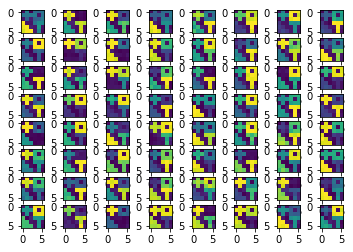

In [190]:
# show some random generated samples from the last epoch
plt.subplots(8,8)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(sample[i,:].view(6,6))


# vae with rsample

In [14]:
from torch.distributions import Normal

In [6]:
class myVAE2(nn.Module):
    def __init__(self):
        super(myVAE2, self).__init__()

        self.fc1 = nn.Linear(36, 100)
        self.fc21 = nn.Linear(100, 10)
        self.fc22 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 100)
        self.fc4 = nn.Linear(100, 36)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 36))
        var = logvar.exp()
        q = Normal(mu, var)
        z = q.rsample()
        return self.decode(z), mu, logvar
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 36), reduction='sum')
        
        var = logvar.exp()
        q = Normal(mu, var)
        p = Normal(torch.zeros_like(mu), torch.ones_like(var))
#         KLD = nn.KLDivLoss()
        KLD = torch.distributions.kl.kl_divergence(q, p).sum(-1).mean()
    
        return BCE + KLD


In [8]:
def train(model, epoch, traindataloader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(traindataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(traindataloader.dataset),
                100. * batch_idx / len(traindataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(traindataloader.dataset)))


In [9]:
args = arg(64, False, 10,10)
device = torch.device("cuda" if args.cuda else "cpu")
model = myVAE2().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
Path("./results_D36_rsample").mkdir(parents=True, exist_ok=True)

In [14]:
for epoch in range(1, args.epochs + 1):
    train(model, epoch, mydataloader)
    with torch.no_grad():
        sample = torch.randn(64, 10).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 6, 6),
                   'results_D36_rsample/sample' + str(epoch) + '.png')

Train Epoch: 1 [0/500 (0%)]	Loss: 74.644203
Train Epoch: 1 [320/500 (62%)]	Loss: 70.382782
====> Epoch: 1 Average loss: 71.3912
Train Epoch: 2 [0/500 (0%)]	Loss: 67.599548
Train Epoch: 2 [320/500 (62%)]	Loss: 67.297768
====> Epoch: 2 Average loss: 66.4096
Train Epoch: 3 [0/500 (0%)]	Loss: 65.214973
Train Epoch: 3 [320/500 (62%)]	Loss: 63.361115
====> Epoch: 3 Average loss: 64.5322
Train Epoch: 4 [0/500 (0%)]	Loss: 65.155304
Train Epoch: 4 [320/500 (62%)]	Loss: 61.555935
====> Epoch: 4 Average loss: 62.5511
Train Epoch: 5 [0/500 (0%)]	Loss: 60.257526
Train Epoch: 5 [320/500 (62%)]	Loss: 58.111618
====> Epoch: 5 Average loss: 57.8267
Train Epoch: 6 [0/500 (0%)]	Loss: 54.136284
Train Epoch: 6 [320/500 (62%)]	Loss: 50.910278
====> Epoch: 6 Average loss: 51.5165
Train Epoch: 7 [0/500 (0%)]	Loss: 50.441326
Train Epoch: 7 [320/500 (62%)]	Loss: 48.686867
====> Epoch: 7 Average loss: 48.1472
Train Epoch: 8 [0/500 (0%)]	Loss: 45.953655
Train Epoch: 8 [320/500 (62%)]	Loss: 44.779762
====> Epoch: 

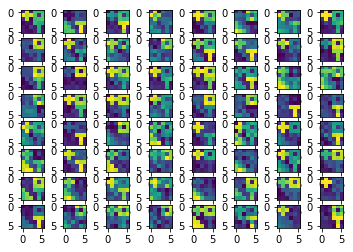

In [15]:
# show some random generated samples from the last epoch
plt.subplots(8,8)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(sample[i,:].view(6,6))


In [20]:
x_recon, mu, logvar = model.forward(my_dataset[0][0])

In [22]:
mu.mean()

tensor(0.6888, grad_fn=<MeanBackward0>)

In [25]:
logvar.exp().mean()

tensor(0.1457, grad_fn=<MeanBackward0>)

# custom loss and layers

In [243]:
class myVAE3(nn.Module):
    def __init__(self, X_dim, hidden_dim, truncation_level):
        super(myVAE3, self).__init__()
        # some common parameters
        self.X_dim = X_dim # D
        self.truncation = truncation_level # K
        self.hidden = hidden_dim
        
        # encoder layers
        self.fc1 = nn.Linear(self.X_dim, self.hidden)
        self.fc2_alpha = nn.Linear(self.hidden, 1)
        self.fc2_tau_A = nn.Linear(self.hidden, 1)
        self.fc2_tau_n = nn.Linear(self.hidden, 1)
        self.fc2_v = nn.Linear(self.hidden, self.truncation)
        self.fc2_Z = nn.Linear(self.hidden, self.truncation)
        self.fc2_A = nn.Linear(self.hidden, self.truncation*self.X_dim)
        
        
        # decoder layers 
        self.fc3 = nn.Linear(self.truncation*self.X_dim + self.truncation + 1, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, self.X_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        logalpha = self.fc2_alpha(h1)
        logtau_A = self.fc2_tau_A(h1)
        logtau_n = self.fc2_tau_n(h1)
        logv = self.fc2_v(h1)
        Z = F.sigmoid(self.fc2_Z(h1))
        A = self.fc2_A(h1)
        return logalpha, logtau_A, logtau_n, logv, Z, A

    def decode(self, Z, A, logtau_n):
        h2 = F.relu(self.fc3(torch.cat((Z,A,logtau_n), dim = 1)))
        return torch.sigmoid(self.fc4(h2))

    def forward(self, x):
        logalpha, logtau_A, logtau_n, logv, Z, A = self.encode(x.view(-1, self.X_dim))
        x_reconstruct = self.decode(Z, A, logtau_n)
        return x_reconstruct, logalpha, logtau_A, logtau_n, logv, Z, A
    
    def loss_function(self, recon_x, x):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, self.X_dim), reduction='sum')

        return BCE 


In [244]:
def train(model, epoch, traindataloader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(traindataloader):
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstruct, logalpha, logtau_A, logtau_n, logv, Z, A = model(data)
        loss = model.loss_function(x_reconstruct, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(traindataloader.dataset),
                100. * batch_idx / len(traindataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(traindataloader.dataset)))


In [245]:
args = arg(64, False, 10,10)
device = torch.device("cuda" if args.cuda else "cpu")
model = myVAE3(X_dim = 36, hidden_dim = 100, truncation_level = 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
Path("./results_D36_custom").mkdir(parents=True, exist_ok=True)

In [246]:
for epoch in range(1, args.epochs + 1):
    train(model, epoch, mydataloader)
#     with torch.no_grad():
#         sample = torch.randn(64, 10).to(device)
#         sample = model.decode(sample).cpu()
#         save_image(sample.view(64, 1, 6, 6),
#                    'results_D36_custom/sample' + str(epoch) + '.png')

/Users/joey/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/500 (0%)]	Loss: 24.915075
Train Epoch: 1 [320/500 (62%)]	Loss: 22.705618
====> Epoch: 1 Average loss: 23.3288
Train Epoch: 2 [0/500 (0%)]	Loss: 20.973221
Train Epoch: 2 [320/500 (62%)]	Loss: 19.546665
====> Epoch: 2 Average loss: 20.2792
Train Epoch: 3 [0/500 (0%)]	Loss: 18.609722
Train Epoch: 3 [320/500 (62%)]	Loss: 17.038853
====> Epoch: 3 Average loss: 17.6324
Train Epoch: 4 [0/500 (0%)]	Loss: 15.873297
Train Epoch: 4 [320/500 (62%)]	Loss: 14.642612
====> Epoch: 4 Average loss: 15.4374
Train Epoch: 5 [0/500 (0%)]	Loss: 14.933339
Train Epoch: 5 [320/500 (62%)]	Loss: 14.910311
====> Epoch: 5 Average loss: 14.8624
Train Epoch: 6 [0/500 (0%)]	Loss: 14.570356
Train Epoch: 6 [320/500 (62%)]	Loss: 14.722872
====> Epoch: 6 Average loss: 14.6447
Train Epoch: 7 [0/500 (0%)]	Loss: 14.756136
Train Epoch: 7 [320/500 (62%)]	Loss: 14.185382
====> Epoch: 7 Average loss: 14.4454
Train Epoch: 8 [0/500 (0%)]	Loss: 14.403946
Train Epoch: 8 [320/500 (62%)]	Loss: 13.972256
====> Epoch: 

/Users/joey/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


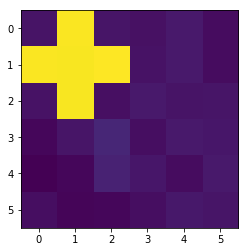

In [249]:
logalpha, logtau_A, logtau_n, logv, Z, A = model.encode(my_dataset[2][0].view(-1,36))
recons = model.decode(Z, A, logtau_n)
plt.imshow(recons.view(6,6).detach().numpy())

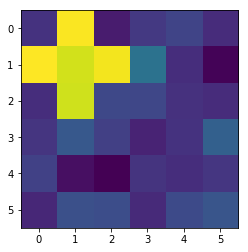

In [250]:
plt.imshow(my_dataset[2][0].view(6,6).detach().numpy())


# IBP

In [15]:
class myVAE4(nn.Module):
    def __init__(self, X_dim, hidden_dim, truncation_level):
        super(myVAE4, self).__init__()
        # some common parameters
        self.X_dim = X_dim # D
        self.truncation = truncation_level # K
        self.hidden = hidden_dim
        
        # prior distributions
        self.alpha_0 = torch.Tensor([1.1,1.1])
        self.p_alpha = torch.distributions.Gamma(self.alpha_0[0], self.alpha_0[1])
        self.tau_A_0 = torch.Tensor([2.1,2.1])
        self.p_tau_A = torch.distributions.Gamma(self.tau_A_0[0], self.tau_A_0[1])
        self.tau_n_0 = torch.Tensor([2.1,2.1])
        self.p_tau_n = torch.distributions.Gamma(self.tau_n_0[0], self.tau_n_0[1])
        
        alpha = self.p_alpha.rsample()
        self.p_v = torch.distributions.Beta(alpha,torch.Tensor([1]))
        
        v = self.p_v.rsample(sample_shape = torch.Size([self.truncation])).view(-1)
        pi = torch.cumprod(v,0)
        
        self.p_Z = torch.distributions.ContinuousBernoulli(pi)
        
        tau_A = self.p_tau_A.rsample()
        self.p_A = torch.distributions.Normal(torch.zeros((self.truncation*self.X_dim)), tau_A)
        
        # encoder layers
        self.fc1 = nn.Linear(self.X_dim, self.hidden)
        self.fc2_rho_alpha = nn.Linear(self.hidden, 2)
        self.fc2_rho_tau_A = nn.Linear(self.hidden, 2)
        self.fc2_rho_tau_n = nn.Linear(self.hidden, 2)
        self.fc2_nu = nn.Linear(self.hidden, self.truncation*2)
#         self.fc2_Z = nn.Linear(self.hidden, self.truncation) # Z is from v
        self.fc2_A = nn.Linear(self.hidden, self.truncation*self.X_dim)
        
        # decoder layers 
        self.fc3 = nn.Linear(self.truncation + self.truncation*self.X_dim + 2, self.hidden)
        self.fc4 = nn.Linear(self.hidden, self.X_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        
        log_rho_alpha = self.fc2_rho_alpha(h1)
        self.q_alpha = torch.distributions.Gamma(log_rho_alpha.exp()[:,0], log_rho_alpha.exp()[:,1])
        
        log_rho_tau_A = self.fc2_rho_tau_A(h1)
        
        self.q_tau_A = torch.distributions.Gamma(log_rho_tau_A.exp()[:,0], log_rho_tau_A.exp()[:,1])
        
        log_rho_tau_n = self.fc2_rho_tau_n(h1)
        self.q_tau_n = torch.distributions.Gamma(log_rho_tau_n.exp()[:,0], log_rho_tau_n.exp()[:,1])
        
        log_rho_nu = self.fc2_nu(h1)
        self.q_nu = torch.distributions.Beta(log_rho_nu.exp()[:,0], log_rho_nu.exp()[:,1])
        
        v = self.q_nu.rsample(sample_shape = torch.Size([self.truncation])).T
        self.q_Z = torch.distributions.ContinuousBernoulli(v)
        Z = self.q_Z.rsample()
        
        phi_A = self.fc2_A(h1) # only the mean or both mean and var?
        tau_A = self.q_tau_A.rsample()
        
        self.q_A = torch.distributions.Normal(phi_A, tau_A.view(tau_A.shape[0],1).expand(phi_A.shape))
        A = self.q_A.rsample()
        
        return log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A

    def decode(self, Z, A, log_rho_tau_n):
        h3 = F.relu(self.fc3(torch.cat([Z, A, log_rho_tau_n], dim = 1)))
        recon_x = torch.sigmoid(F.relu(self.fc4(h3)))
        return recon_x

    def forward(self, x):
        log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A = self.encode(x.view(-1, self.X_dim))
        recon_x = self.decode(Z, A, log_rho_tau_n)
        return recon_x, log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A
    
    def loss_function(self, recon_x, x):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, self.X_dim), reduction='sum')
        
        KL_alpha = torch.distributions.kl.kl_divergence(self.q_alpha, self.p_alpha).sum(-1)
        
        KL_tau_A = torch.distributions.kl.kl_divergence(self.q_tau_A, self.p_tau_A).sum(-1)
        
        KL_tau_n = torch.distributions.kl.kl_divergence(self.q_tau_n, self.p_tau_n).sum(-1)
        
        KL_v = torch.distributions.kl.kl_divergence(self.q_nu, self.p_v).sum(-1)
        
        KL_A = torch.distributions.kl.kl_divergence(self.q_A, self.p_A).sum(-1).mean()
        
        KL_Z = torch.distributions.kl.kl_divergence(self.q_Z, self.p_Z).sum(-1).mean()
        
#         losses = [BCE, KL_alpha, KL_tau_A, KL_tau_n, KL_v, KL_A, KL_Z]
#         print(losses)
        return BCE + 1*(KL_alpha + KL_tau_A + KL_tau_n + KL_v + KL_A + KL_Z)


In [16]:
def train(model, epoch, traindataloader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(traindataloader):
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstruct, logalpha, logtau_A, logtau_n, logv, Z, A = model(data)
        loss = model.loss_function(x_reconstruct, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(traindataloader.dataset),
                100. * batch_idx / len(traindataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(traindataloader.dataset)))


In [17]:
args = arg(32, False, 10,10)
mydataloader = DataLoader(my_dataset, batch_size = args.batch_size, shuffle = True)
device = torch.device("cuda" if args.cuda else "cpu")
model = myVAE4(X_dim = 36, hidden_dim = 100, truncation_level = 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
Path("./results_D36_sample_only_decoder").mkdir(parents=True, exist_ok=True)

In [18]:
for epoch in range(1, 30 + 1):
    train(model, epoch, mydataloader)
#     with torch.no_grad():
#         sample = torch.randn(64, 10).to(device)
#         sample = model.decode(sample).cpu()
#         save_image(sample.view(64, 1, 6, 6),
#                    'results_D36_custom/sample' + str(epoch) + '.png')

Train Epoch: 1 [0/500 (0%)]	Loss: 58.636841
Train Epoch: 1 [320/500 (62%)]	Loss: 46.879452
====> Epoch: 1 Average loss: 41.9488
Train Epoch: 2 [0/500 (0%)]	Loss: 40.373783
Train Epoch: 2 [320/500 (62%)]	Loss: 34.317844
====> Epoch: 2 Average loss: 35.6868
Train Epoch: 3 [0/500 (0%)]	Loss: 31.740463
Train Epoch: 3 [320/500 (62%)]	Loss: 31.114807
====> Epoch: 3 Average loss: 32.0460
Train Epoch: 4 [0/500 (0%)]	Loss: 31.560354
Train Epoch: 4 [320/500 (62%)]	Loss: 25.764555
====> Epoch: 4 Average loss: 27.9549
Train Epoch: 5 [0/500 (0%)]	Loss: 27.134487
Train Epoch: 5 [320/500 (62%)]	Loss: 25.698744
====> Epoch: 5 Average loss: 26.8106
Train Epoch: 6 [0/500 (0%)]	Loss: 25.392954
Train Epoch: 6 [320/500 (62%)]	Loss: 24.910873
====> Epoch: 6 Average loss: 25.7339
Train Epoch: 7 [0/500 (0%)]	Loss: 26.011110
Train Epoch: 7 [320/500 (62%)]	Loss: 25.867384
====> Epoch: 7 Average loss: 25.5053
Train Epoch: 8 [0/500 (0%)]	Loss: 25.520363
Train Epoch: 8 [320/500 (62%)]	Loss: 24.647833
====> Epoch: 

In [21]:
model.eval()

myVAE4(
  (fc1): Linear(in_features=36, out_features=100, bias=True)
  (fc2_rho_alpha): Linear(in_features=100, out_features=2, bias=True)
  (fc2_rho_tau_A): Linear(in_features=100, out_features=2, bias=True)
  (fc2_rho_tau_n): Linear(in_features=100, out_features=2, bias=True)
  (fc2_nu): Linear(in_features=100, out_features=20, bias=True)
  (fc2_A): Linear(in_features=100, out_features=360, bias=True)
  (fc3): Linear(in_features=372, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=36, bias=True)
)

tensor([[0.2946, 0.0062, 0.0251, 0.1931, 0.0427, 0.0937, 0.0782, 0.1978, 0.0305,
         0.0739]], grad_fn=<SWhereBackward>)


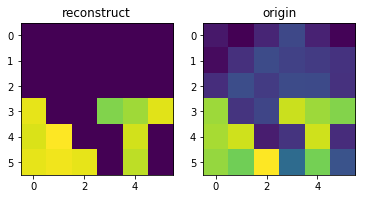

In [24]:
training_sample = my_dataset[1][0]
logalpha, logtau_A, logtau_n, logv, Z, A = model.encode(training_sample.view(-1,36))
recons = model.decode(Z, A, logtau_n)
plt.subplot(1,2,1)
plt.imshow(recons.view(6,6).detach().numpy())
plt.title('reconstruct')
plt.subplot(1,2,2)
plt.imshow(training_sample.view(6,6).detach().numpy())
plt.title('origin')
print(Z)

In [31]:
allZ = np.zeros((len(my_dataset), Z.shape[1]))
for i in range(len(my_dataset)):
    training_sample = my_dataset[i][0]
    logalpha, logtau_A, logtau_n, logv, Z, A = model.encode(training_sample.view(-1,36))
    allZ[i,:] = Z.detach().numpy()

In [67]:
label = np.loadtxt('Z.txt')
label = label.astype(int)
label = label.tolist()

for i in range(len(label)):
    label[i] = ''.join(list(map(str,label[i])))

In [71]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cat_label = le.fit_transform(label)

In [76]:
from sklearn.manifold import TSNE
Z_embedded = TSNE(n_components=2).fit_transform(allZ)
Z_embedded.shape

(500, 2)

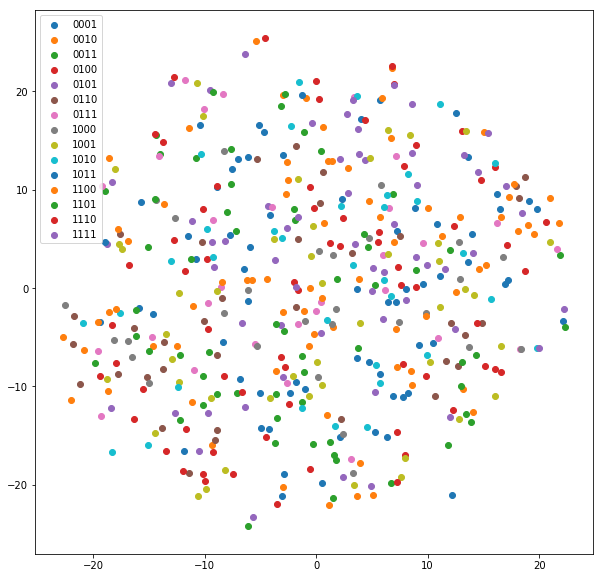

In [81]:
plt.figure(figsize = (10,10))
for i in range(len(le.classes_)):
    idx = cat_label==i
    plt.scatter(Z_embedded[idx,0], Z_embedded[idx,1], label = le.classes_[i])
plt.legend()
plt.show()

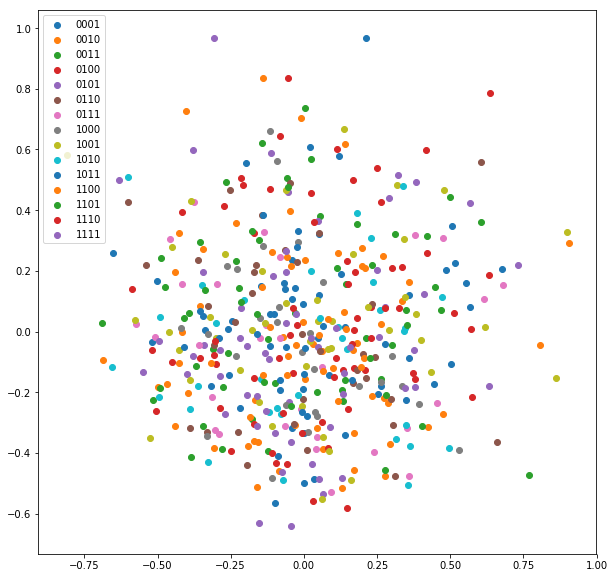

In [82]:
# pca
from sklearn.decomposition import PCA
Z_embedded = PCA(n_components=2).fit_transform(allZ)
plt.figure(figsize = (10,10))
for i in range(len(le.classes_)):
    idx = cat_label==i
    plt.scatter(Z_embedded[idx,0], Z_embedded[idx,1], label = le.classes_[i])
plt.legend()
plt.show()

In [ ]:
latent space clusters
gumble 

# sampling decoder

In [497]:
class myVAE5(nn.Module):
    def __init__(self, X_dim, hidden_dim, truncation_level):
        super(myVAE5, self).__init__()
        # some common parameters
        self.X_dim = X_dim # D
        self.truncation = truncation_level # K
        self.hidden = hidden_dim
        
        # prior distributions
        self.alpha_0 = torch.Tensor([1.1,1.1])
        self.p_alpha = torch.distributions.Gamma(self.alpha_0[0], self.alpha_0[1])
        self.tau_A_0 = torch.Tensor([2.1,2.1])
        self.p_tau_A = torch.distributions.Gamma(self.tau_A_0[0], self.tau_A_0[1])
        self.tau_n_0 = torch.Tensor([2.1,2.1])
        self.p_tau_n = torch.distributions.Gamma(self.tau_n_0[0], self.tau_n_0[1])
        
        alpha = self.p_alpha.rsample()
        self.p_v = torch.distributions.Beta(alpha,torch.Tensor([1]))
        
        v = self.p_v.rsample(sample_shape = torch.Size([self.truncation])).view(-1)
        pi = torch.cumprod(v,0)
        
        self.p_Z = torch.distributions.ContinuousBernoulli(pi)
        
        tau_A = self.p_tau_A.rsample()
        self.p_A = torch.distributions.Normal(torch.zeros((self.truncation*self.X_dim)), tau_A)
        
        # encoder layers
        self.fc1 = nn.Linear(self.X_dim, self.hidden)
        self.fc2_rho_alpha = nn.Linear(self.hidden, 2)
        self.fc2_rho_tau_A = nn.Linear(self.hidden, 2)
        self.fc2_rho_tau_n = nn.Linear(self.hidden, 2)
        self.fc2_nu = nn.Linear(self.hidden, self.truncation*2)
#         self.fc2_Z = nn.Linear(self.hidden, self.truncation)
        self.fc2_A = nn.Linear(self.hidden, self.truncation*self.X_dim)
        
        #  no decoder layers because P(X|W) is known
        # 

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        
        log_rho_alpha = self.fc2_rho_alpha(h1)
        self.q_alpha = torch.distributions.Gamma(log_rho_alpha.exp()[:,0], log_rho_alpha.exp()[:,1])
        
        log_rho_tau_A = self.fc2_rho_tau_A(h1)
        
        self.q_tau_A = torch.distributions.Gamma(log_rho_tau_A.exp()[:,0], log_rho_tau_A.exp()[:,1])
        
        log_rho_tau_n = self.fc2_rho_tau_n(h1)
        self.q_tau_n = torch.distributions.Gamma(log_rho_tau_n.exp()[:,0], log_rho_tau_n.exp()[:,1])
        
        log_rho_nu = self.fc2_nu(h1)
        self.q_nu = torch.distributions.Beta(log_rho_nu.exp()[:,0], log_rho_nu.exp()[:,1])
        
        v = self.q_nu.rsample(sample_shape = torch.Size([self.truncation])).T
        self.q_Z = torch.distributions.ContinuousBernoulli(v)
        Z = self.q_Z.rsample()
        
        phi_A = self.fc2_A(h1) # only the mean or both mean and var?
        tau_A = self.q_tau_A.rsample()
        
        self.q_A = torch.distributions.Normal(phi_A, tau_A.view(tau_A.shape[0],1).expand(phi_A.shape))
        A = self.q_A.rsample()
        
        return log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A

    def decode(self, Z, A, log_rho_tau_n):
        tau_n = self.q_tau_n.rsample()
        p_x_w = Normal(Z.view(-1,1,10).matmul(A.view(-1,10,36)).view(-1,36), tau_n.view(tau_n.shape[0],1).expand((-1,36)))
        
        return torch.sigmoid(p_x_w.rsample())

    def forward(self, x):
        log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A = self.encode(x.view(-1, self.X_dim))
        x_reconstruct = self.decode(Z, A, log_rho_tau_n)
        return x_reconstruct, log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A
    
    def loss_function(self, recon_x, x):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, self.X_dim), reduction='sum')
        
        KL_alpha = torch.distributions.kl.kl_divergence(self.q_alpha, self.p_alpha).sum(-1)
        
        KL_tau_A = torch.distributions.kl.kl_divergence(self.q_tau_A, self.p_tau_A).sum(-1)
        
        KL_tau_n = torch.distributions.kl.kl_divergence(self.q_tau_n, self.p_tau_n).sum(-1)
        
        KL_v = torch.distributions.kl.kl_divergence(self.q_nu, self.p_v).sum(-1)
        
        KL_A = torch.distributions.kl.kl_divergence(self.q_A, self.p_A).sum(-1).mean()
        
        KL_Z = torch.distributions.kl.kl_divergence(self.q_Z, self.p_Z).sum(-1).mean()
        
        
#         losses = [BCE, KL_alpha, KL_tau_A, KL_tau_n, KL_v, KL_A, KL_Z]
#         print(losses)
        return BCE + 1*(KL_alpha + KL_tau_A + KL_tau_n + KL_v + KL_A + KL_Z)


In [491]:
args = arg(32, False, 10,10)
mydataloader = DataLoader(my_dataset, batch_size = args.batch_size, shuffle = True)
device = torch.device("cuda" if args.cuda else "cpu")
model = myVAE5(X_dim = 36, hidden_dim = 100, truncation_level = 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
Path("./results_D36_ZA").mkdir(parents=True, exist_ok=True)

In [492]:
for epoch in range(1, 30 + 1):
    train(model, epoch, mydataloader)
#     with torch.no_grad():
#         sample = torch.randn(64, 10).to(device)
#         sample = model.decode(sample).cpu()
#         save_image(sample.view(64, 1, 6, 6),
#                    'results_D36_custom/sample' + str(epoch) + '.png')

Train Epoch: 1 [0/500 (0%)]	Loss: 60.171165
Train Epoch: 1 [320/500 (62%)]	Loss: 43.578655
====> Epoch: 1 Average loss: 49.6820
Train Epoch: 2 [0/500 (0%)]	Loss: 39.689453
Train Epoch: 2 [320/500 (62%)]	Loss: 35.391060
====> Epoch: 2 Average loss: 37.9449
Train Epoch: 3 [0/500 (0%)]	Loss: 34.698544
Train Epoch: 3 [320/500 (62%)]	Loss: 33.045204
====> Epoch: 3 Average loss: 33.2931
Train Epoch: 4 [0/500 (0%)]	Loss: 31.194283
Train Epoch: 4 [320/500 (62%)]	Loss: 30.037127
====> Epoch: 4 Average loss: 29.5680
Train Epoch: 5 [0/500 (0%)]	Loss: 30.337919
Train Epoch: 5 [320/500 (62%)]	Loss: 27.761497
====> Epoch: 5 Average loss: 28.3154
Train Epoch: 6 [0/500 (0%)]	Loss: 28.379263
Train Epoch: 6 [320/500 (62%)]	Loss: 25.828651
====> Epoch: 6 Average loss: 26.5838
Train Epoch: 7 [0/500 (0%)]	Loss: 25.242836
Train Epoch: 7 [320/500 (62%)]	Loss: 24.985950
====> Epoch: 7 Average loss: 25.4345
Train Epoch: 8 [0/500 (0%)]	Loss: 24.023260
Train Epoch: 8 [320/500 (62%)]	Loss: 25.227455
====> Epoch: 

tensor([[0.3043, 0.9509, 0.1556, 0.8184, 0.0649, 0.8027, 0.1802, 0.2833, 0.6977,
         0.1362]], grad_fn=<SWhereBackward>)


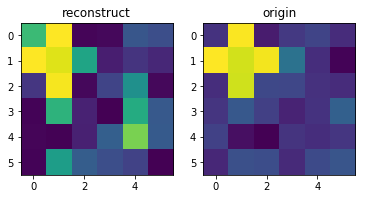

In [499]:
training_sample = my_dataset[2][0]

logalpha, logtau_A, logtau_n, logv, Z, A = model.encode(training_sample.view(-1,36))
recons = model.decode(Z, A, logtau_n)
plt.subplot(1,2,1)
plt.imshow(recons.view(6,6).detach().numpy())
plt.title('reconstruct')
plt.subplot(1,2,2)
plt.imshow(training_sample.view(6,6).detach().numpy())
plt.title('origin')
print(Z)

In [ ]:
Z

In [425]:
log_rho_alpha, log_rho_tau_A, log_rho_tau_n, log_rho_nu, Z, A = model.encode(my_dataset[5][0].view(-1,36))


In [426]:
log_rho_alpha.exp()

tensor([[1.1051, 1.1219]], grad_fn=<ExpBackward>)

In [445]:
log_rho_tau_A.exp()

tensor([[ 2.4805, 24.7920]], grad_fn=<ExpBackward>)

In [452]:
log_rho_tau_n.exp(), log_rho_tau_n.exp()[0,0]/log_rho_tau_n.exp()[0,1]

(tensor([[ 0.3291, 19.2207]], grad_fn=<ExpBackward>),
 tensor(0.0171, grad_fn=<DivBackward0>))

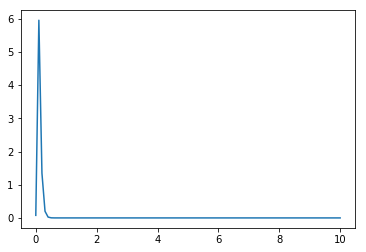

In [446]:
pp = torch.distributions.Gamma(2.4805, 24.7920)
xx = torch.linspace(0.001,10)
plt.plot(xx, pp.log_prob(xx).exp())

# POS vectors

In [ ]:
class CustomTextDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.text_labels = np.loadtxt(annotations_file)
        self.text_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, str(idx) + '.jpg')
        image = read_image(img_path).float()
        image = image/image.max()
        label = self.img_labels[idx, :]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label).type(torch.int)
        return image, label


In [ ]:
my_dataset = CustomImageDataset('Z.txt' ,'./img', target_transform = torch.from_numpy)

mydataloader = DataLoader(my_dataset, batch_size = 12, shuffle = True)
